In [1]:
# data processing
import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# model
from sklearn.linear_model import LinearRegression

# metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH_TO_FILE = 'LR_insurance.csv'

In [3]:
df = pd.read_csv(PATH_TO_FILE)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
smoker_label_encoder = LabelEncoder()
df['smoker'] = smoker_label_encoder.fit_transform(df['smoker'].values)

sex_label_encoder = LabelEncoder()
df['sex'] = sex_label_encoder.fit_transform(df['sex'].values)

In [8]:
sex_label_encoder.classes_

array(['female', 'male'], dtype=object)

In [9]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [10]:
# check the amount of males and females and their ratio
print(f'Males: {df[df["sex"]==1].size},\tFemales: {df[df["sex"]==0].size}')
print(f'Males/Females ratio = {df[df["sex"]==1].size / df[df["sex"]==0].size}')

Males: 4732,	Females: 4634
Males/Females ratio = 1.0211480362537764


We sea that the data is balanced in terms of sex

In [11]:
np.unique(df['region'])

array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

<Axes: xlabel='region', ylabel='count'>

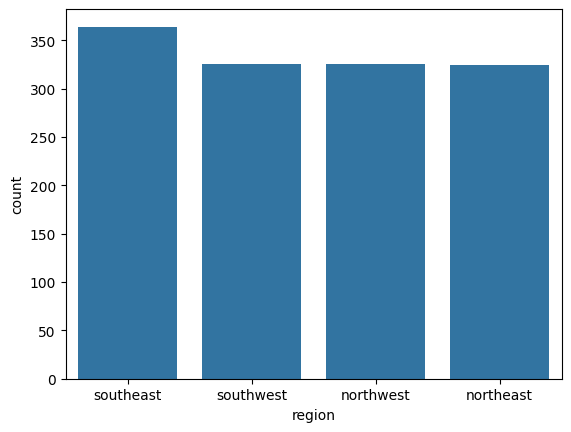

In [12]:
sns.barplot(df['region'].value_counts())

Regions types are balanced 

let's encode label 'region'

In [13]:
region_encoder = LabelEncoder()
df['region'] = region_encoder.fit_transform(df['region'])

In [14]:
region_encoder.classes_

array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)

let's look age destribution

<Axes: xlabel='age', ylabel='Count'>

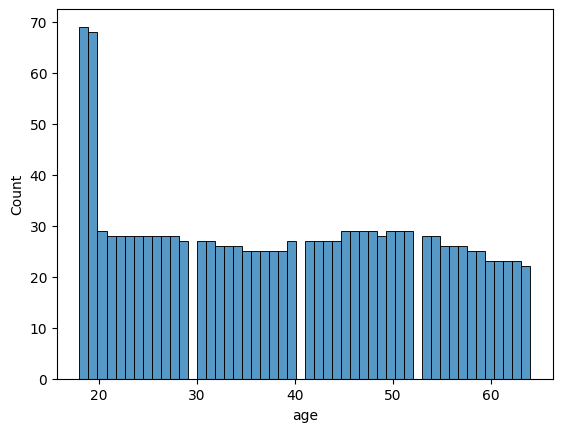

In [15]:
sns.histplot(df['age'], bins=50)

In [16]:
print(f'min age: {df["age"].min()}\tmax age: {df["age"].max()}')

min age: 18	max age: 64


<Axes: xlabel='bmi', ylabel='Count'>

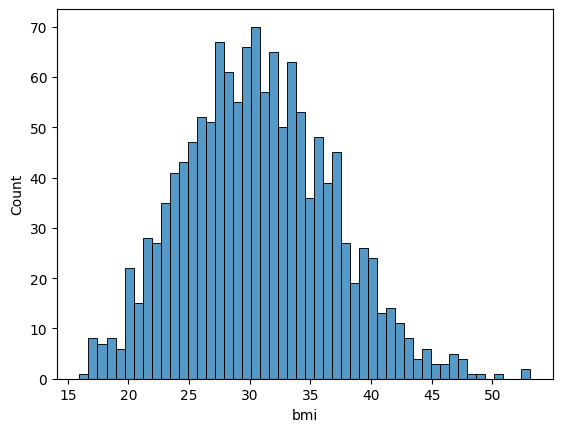

In [17]:
sns.histplot(df["bmi"], bins=50)

we have some outlayers in bmis

<Axes: xlabel='children', ylabel='count'>

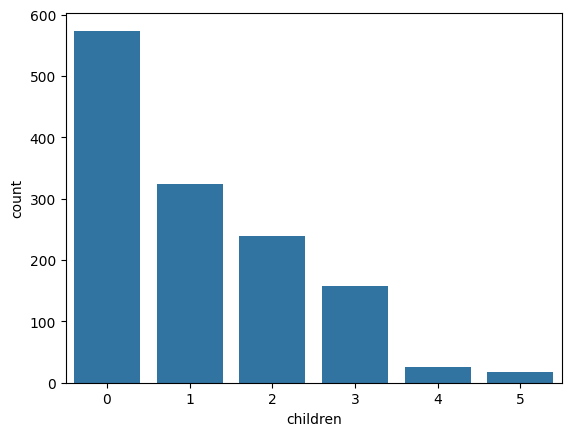

In [18]:
sns.barplot(df["children"].value_counts())

In [19]:
df["children"].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

сделаем так: соберем данные о детях так, чтобы разделили на три равные группы

    1. без детей
    2. один ребенок
    3. два и более

In [51]:
children = df['children'].values
no_children = np.where(children == 0, 1, 0)
one_child = np.where(children == 1, 1, 0)
geq_two_children = np.where(children >= 2, 1, 0)

print(children.shape, no_children.shape, one_child.shape, geq_two_children.shape)
print(f'total samples amount: {children.size}')
print(f'no children samples: {no_children.sum()} is {no_children.sum() / children.size * 100:.2f}%')
print(f'one child samples: {one_child.sum()} is {one_child.sum()/ children.size * 100:.2f}%')
print(f'two and more children samples: {geq_two_children.sum()} is {geq_two_children.sum() / children.size * 100:.2f}%')


(1328,) (1328,) (1328,) (1328,)
total samples amount: 1328
no children samples: 569 is 42.85%
one child samples: 320 is 24.10%
two and more children samples: 439 is 33.06%


In [52]:
# df['no children'] = no_children
# df['one child'] = one_child
# df['geq two children'] = geq_two_children
# df.drop(columns='children', inplace=True)
# df.head()

<Axes: xlabel='charges', ylabel='Count'>

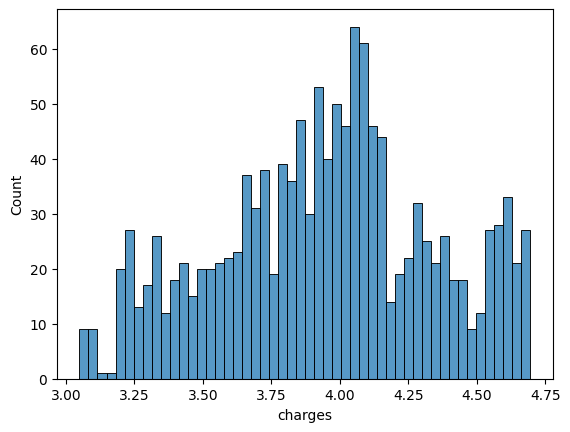

In [53]:
sns.histplot(df['charges'], bins=50)

In [21]:
print(f"samples with charges more than 50000: {df[df['charges']>50000].shape[0]}")

samples with charges more than 50000: 7


In [22]:
print(f'number of samples with bmi more than 50: {df[df["bmi"]>50].shape[0]}')

number of samples with bmi more than 50: 3


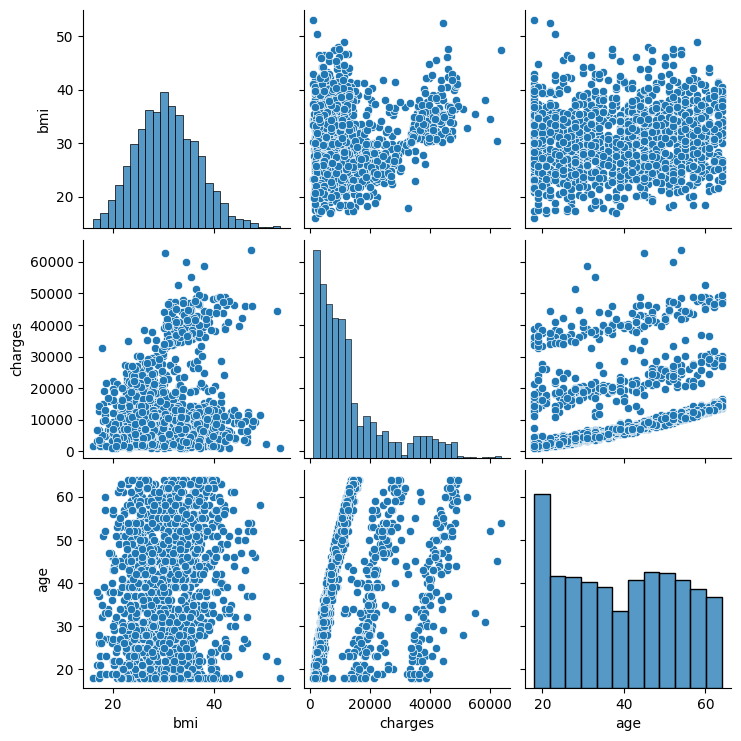

In [23]:
sns.pairplot(df[['bmi', 'charges', 'age']])

In [24]:
bmi, age = df['bmi'], df['age']

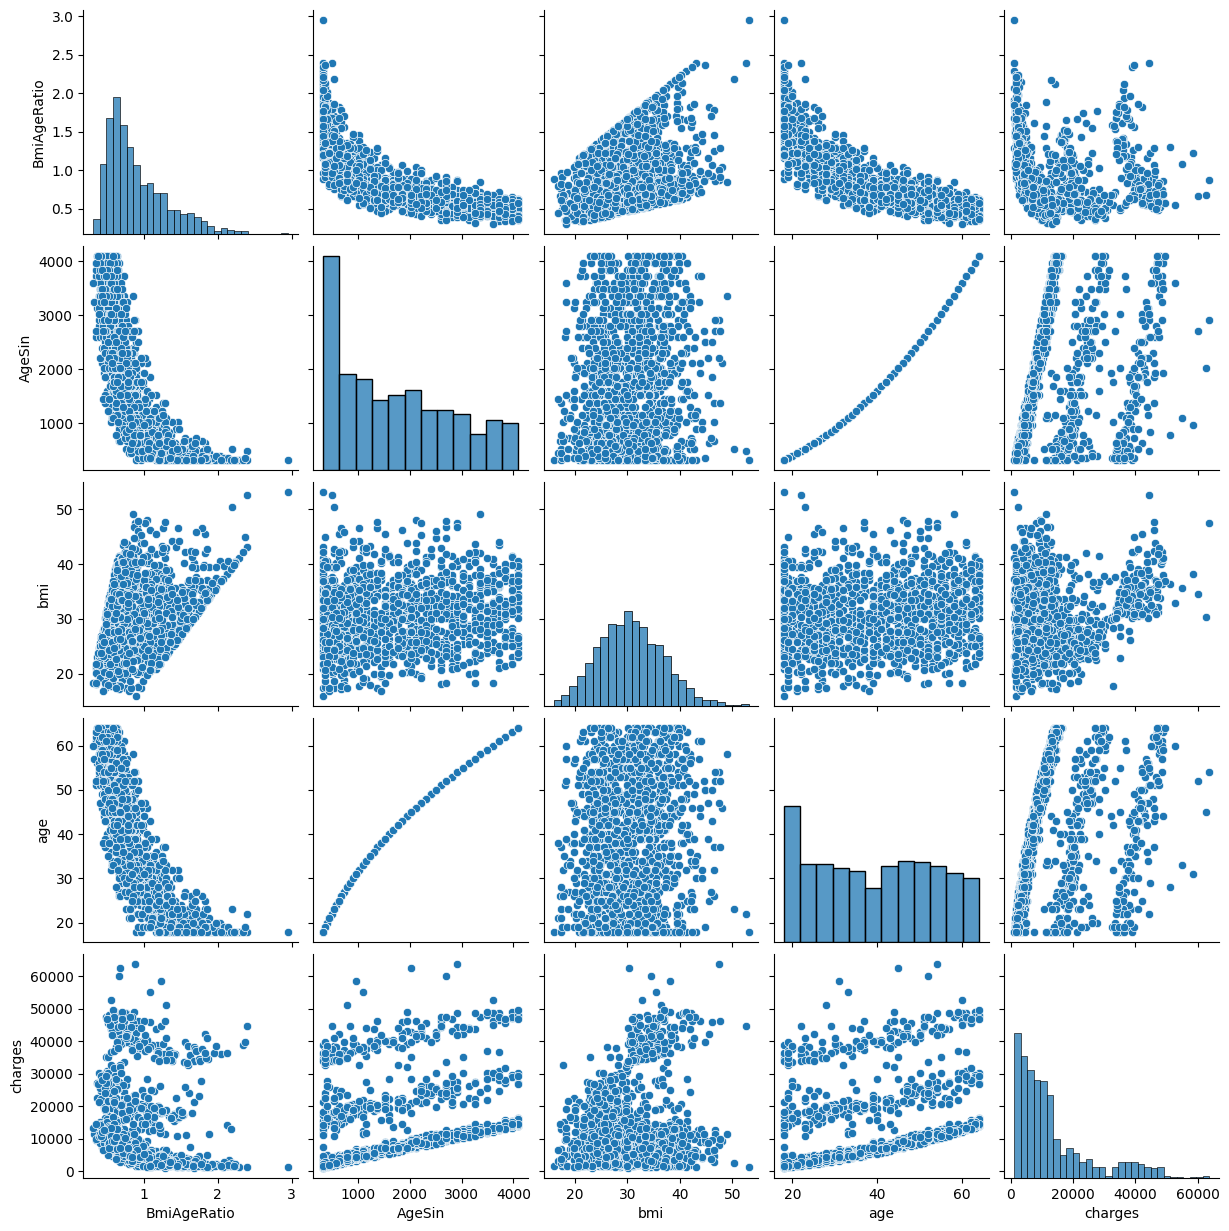

In [25]:
bmi_age_ratio = bmi / age
age_sin = age**2

gen_features = pd.DataFrame({'BmiAgeRatio': bmi_age_ratio, 'AgeSin': age_sin, 
                             'bmi': df['bmi'].values, 'age': df['age'].values,
                             'charges': df['charges'].values})

sns.pairplot(gen_features)

let's drop outlayers

In [26]:
bmi_outlayers = np.argsort(df["bmi"].values)[-3:]
charges_outlayers = np.argsort(df["charges"].values)[-7:]

In [27]:
indeces_to_drop = np.unique(bmi_outlayers.tolist() + charges_outlayers.tolist())
indeces_to_drop.sort()
indeces_to_drop.shape

(10,)

In [28]:
df.shape, df.drop(index=indeces_to_drop, axis=1).shape

((1338, 7), (1328, 7))

In [29]:
df.drop(index=indeces_to_drop, axis=1, inplace=True)

In [30]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [31]:
df['charges'] = np.log10(df['charges'].values)

In [32]:
# X, y = df[['age', 'bmi', 'no children','one child', 'geq two children']].values, df['charges'].values
# X_smoker = df[['age', 'bmi','no children','one child', 'geq two children', 'smoker']].values

X, y = df[['age', 'bmi', 'children']].values, df['charges'].values
X_smoker = df[['age', 'bmi','children', 'smoker']].values

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=20240415)
trainX_smoker, testX_smoker, trainY_smoker, testY_smoker = train_test_split(X_smoker, y, 
                                                                            test_size=0.2, random_state=20240415)

# Train a linear model

In [47]:
# min_max_scaler = MinMaxScaler()
# trainX_scaled = min_max_scaler.fit_transform(trainX)

In [33]:
ols = sm.OLS(trainY, sm.add_constant(trainX)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     159.1
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           4.22e-85
Time:                        11:35:39   Log-Likelihood:                -327.55
No. Observations:                1062   AIC:                             663.1
Df Residuals:                    1058   BIC:                             683.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2016      0.058     55.140      0.000       3.088       3.316
x1             0.0146      0.001     20.137      0.000       0.013       0.016
x2             0.0038      0.002      2.242      0.025       0.000       0.007
x3             0.0516      0.009      6.051      0.000       0.035       0.068
==============================================================================
Omnibus:                      163.517   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.878
Skew:                           1.164   Prob(JB):                     1.10e-53
Kurtosis:                       3.302   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
mse(trainY, ols.predict(sm.add_constant(trainX)))

0.10849745434588665

In [35]:
print(trainY[:10], ols.predict(sm.add_constant(trainX))[:10], sep='\n')

[4.05093539 3.92153896 4.17666299 4.307021   3.67939176 3.23538609
 4.42147659 3.64750162 3.34393956 3.81657736]
[4.17831733 4.12125163 4.32514008 3.78924985 3.84232074 3.62786283
 4.09020617 3.80786825 3.59078209 3.9113653 ]


In [38]:
ols_smoker = sm.OLS(trainY_smoker, sm.add_constant(trainX_smoker)).fit()
ols_smoker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     835.7
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:35:54   Log-Likelihood:                 232.04
No. Observations:                1062   AIC:                            -454.1
Df Residuals:                    1057   BIC:                            -429.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0302      0.035     87.797      0.000       2.963       3.098
x1             0.0153      0.000     35.654      0.000       0.014       0.016
x2             0.0045      0.001      4.430      0.000       0.002       0.006
x3             0.0444      0.005      8.824      0.000       0.035       0.054
x4             0.6659      0.015     44.442      0.000       0.637       0.695
==============================================================================
Omnibus:                      372.936   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1357.275
Skew:                           1.682   Prob(JB):                    1.87e-295
Kurtosis:                       7.400   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Наличие параметра smoker существенно улучшает качество модели

In [39]:
print(f'R^2 score: {r2_score(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')
print(f'MSE score: {mse(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')
print(f'MAPE score: {mape(testY_smoker, ols_smoker.predict(sm.add_constant(testX_smoker)))}')

R^2 score: 0.7581542751118556
MSE score: 0.0361915355480535
MAPE score: 0.029843417048130805


## Permutation Importance

In [40]:
lr = LinearRegression()
lr.fit(trainX_smoker, trainY_smoker)
permut = permutation_importance(lr, trainX_smoker, trainY_smoker, n_repeats=100, random_state=20240415)

In [41]:
print(f'permutation mean: {permut.importances_mean}', f'permutation std: {permut.importances_std}', sep='\n')

permutation mean: [0.58586574 0.00915499 0.03586743 0.89531942]
permutation std: [0.02888924 0.001992   0.00388933 0.0371387 ]


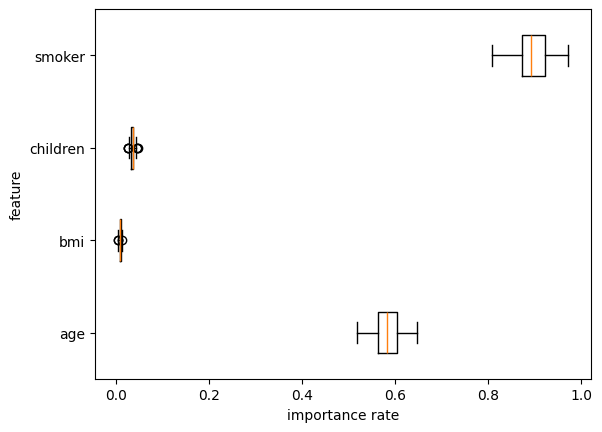

In [43]:
plt.boxplot(permut.importances.T, vert=False, labels=['age', 'bmi', 'children','smoker'])
plt.xlabel('importance rate')
plt.ylabel('feature')
plt.show()

In [45]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [46]:
lr = LinearRegression()
lr.fit(df[df.columns[:-1]].values, df[df.columns[-1]].values)

permut = permutation_importance(lr, df[df.columns[:-1]].values,
                                df[df.columns[-1]].values, 
                                n_repeats=100, random_state=20240415)

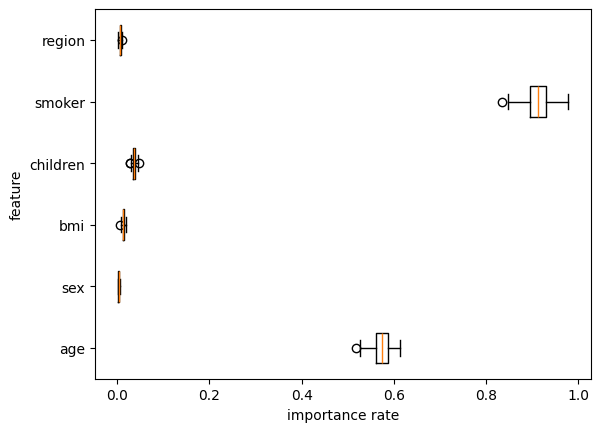

In [50]:
plt.boxplot(permut.importances.T, vert=False, labels=df.columns[:-1])
plt.xlabel('importance rate')
plt.ylabel('feature')
plt.show()

# Categorical features influence

In [152]:
def get_mse_categorical(df, features_in=None):
    columns = ['age', 'bmi']
    if features_in is not None:
        columns += features_in

    X, y = df[columns].values, df['charges'].values
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=20240415)

    lr = LinearRegression()
    lr.fit(trainX, trainY)
    mse_score = mse(testY, lr.predict(testX))
    return mse_score


In [153]:
mse_all_out = get_mse_categorical(df)
mse_no_out = get_mse_categorical(df, ['smoker', 'children', 'region', 'sex'])
mse_children = get_mse_categorical(df, ['children'])
mse_smoker = get_mse_categorical(df, ['smoker'])
mse_region = get_mse_categorical(df, ['region'])
mse_sex = get_mse_categorical(df, ['sex'])
mse_smoker_children = get_mse_categorical(df, ['smoker', 'children'])
mse_smoker_region = get_mse_categorical(df, ['smoker', 'region'])
mse_smoker_sex = get_mse_categorical(df, ['smoker', 'sex'])
mse_children_region = get_mse_categorical(df, ['children', 'region'])
mse_children_sex = get_mse_categorical(df, ['children', 'sex'])
mse_region_sex = get_mse_categorical(df, ['region', 'sex'])
mse_smoker_out = get_mse_categorical(df, ['children', 'region', 'sex'])
mse_children_out = get_mse_categorical(df, ['smoker', 'region', 'sex'])
mse_region_out = get_mse_categorical(df, ['smoker', 'children', 'sex'])
mse_sex_out = get_mse_categorical(df, ['smoker', 'children', 'region'])

In [164]:
mse_df = pd.DataFrame({'features': ['all out', 'no out', 'children',
                           'smoker', 'region', 'sex', 
                           'smoker_children', 'smoker_region',
                           'smoker_sex', 'children_region',
                           'children_sex', 'region_sex',
                           'smoker out', 'children out',
                           'region out', 'sex out'],
                        'features num': [0, 4, 1,
                                          1, 1, 1,
                                          2, 2, 2, 2,
                                          2, 2, 3, 3, 3, 3],
                        'mse': [mse_all_out, mse_no_out, mse_children,
                              mse_smoker, mse_region, mse_sex,
                              mse_smoker_children, mse_smoker_region, 
                              mse_smoker_sex, mse_children_region,
                              mse_children_sex, mse_region_sex, mse_smoker_out,
                              mse_children_out, mse_region_out, mse_sex_out]
                                    })

In [169]:
# mse_df.set_index('features', inplace=True)
mse_df.sort_values(by=['mse'])

,features,features num,mse
15,sex out,3,3.266022e+07
1,no out,4,3.270377e+07
6,smoker_children,2,3.273458e+07
14,region out,3,3.277379e+07
7,smoker_region,2,3.319962e+07
3,smoker,1,3.322690e+07
13,children out,3,3.324135e+07
8,smoker_sex,2,3.326412e+07
4,region,1,1.205726e+08
0,all out,0,1.206535e+08
